In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib
pd.pandas.set_option('display.max_columns', None)

In [2]:
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('datasets/titanic.csv')

In [5]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr


In [6]:
y = 'survived'
vars_num = list(df.select_dtypes(include=['number']).columns)
vars_cat = list(df.select_dtypes(include=['object', 'category']).columns)

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


In [7]:
df[vars_num].isnull().mean()

survived    0.000000
pclass      0.000000
age         0.198653
sibsp       0.000000
parch       0.000000
fare        0.000000
dtype: float64

In [8]:
df[vars_cat].isnull().mean()

sex         0.000000
cabin       0.771044
embarked    0.002245
title       0.000000
dtype: float64

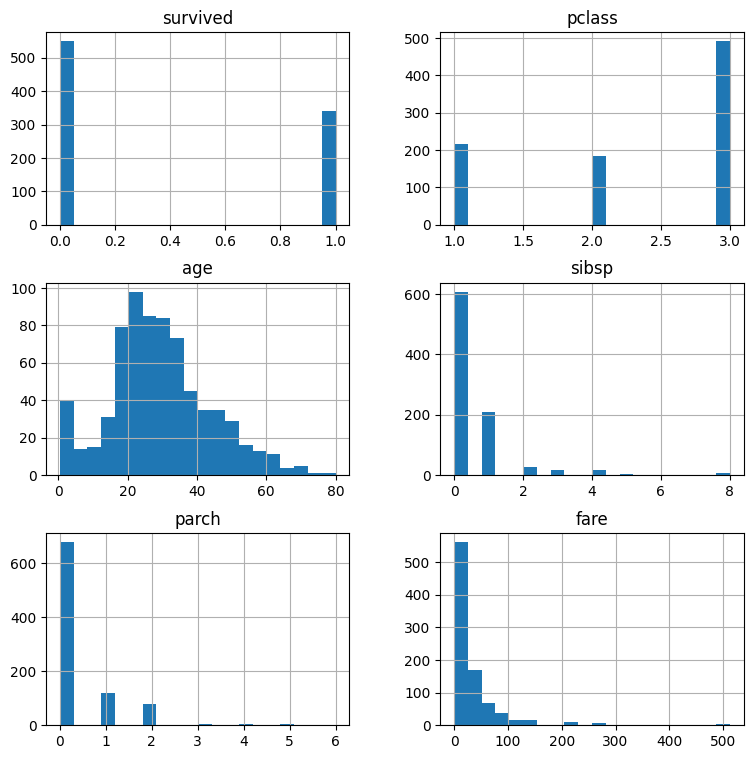

In [9]:
df[vars_num].hist(bins=20, figsize=(9,9))
plt.show()

In [10]:
#df[vars_cat] = df[vars_cat].fillna('Missing')

In [11]:
#one_hot_encoded_df = pd.get_dummies(df, columns=['pclass','sex', 'embarked', 'title'])

In [12]:
#one_hot_encoded_df['cabin'] = one_hot_encoded_df['cabin'].str[0]

In [13]:
#one_hot_encoded_df['age'] = one_hot_encoded_df['age'].fillna(one_hot_encoded_df['age'].median())

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)
from feature_engine.encoding import (
    RareLabelEncoder,
    OneHotEncoder
)

In [15]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    # Extract fist letter of variable

    def __init__(self, variables):
        
        if not isinstance(variables, list):
            raise ValueError('variables should be a list')
        
        self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):

        # so that we do not over-write the original dataframe
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = X[feature].str[0]

        return X

In [16]:
NUMERICAL_VARIABLES = ['age', 'fare']

CATEGORICAL_VARIABLES = ['sex', 'cabin', 'embarked', 'title']

CABIN = ['cabin']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(y,axis=1), df[y],
    test_size=0.2, random_state=0) 

X_train.shape, X_test.shape

((712, 9), (179, 9))

In [20]:
X_train.to_csv('train.csv')

In [21]:
X_test.to_csv('test.csv')

In [23]:
X_test.head(n=10)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
495,3,male,NaN,0,0,14.4583,NaN,C,Mr
648,3,male,NaN,0,0,7.5500,NaN,S,Mr
278,3,male,7.0,4,1,29.1250,NaN,Q,Master
31,1,female,NaN,1,0,146.5208,B78,C,Mrs
255,3,female,29.0,0,2,15.2458,NaN,C,Mrs
298,1,male,NaN,0,0,30.5000,C106,S,Mr
609,1,female,40.0,0,0,153.4625,C125,S,Miss
318,1,female,31.0,0,2,164.8667,C7,S,Miss
484,1,male,25.0,1,0,91.0792,B49,C,Mr
367,3,female,NaN,0,0,7.2292,NaN,C,Mrs


In [36]:
titanic_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # Extract letter from cabin
    ('extract_letter', ExtractLetterTransformer(variables=CABIN)),


    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler()),

    ('Logit', LogisticRegression(C=0.0005, random_state=0)),
])

In [37]:
titanic_pipe.fit(X_train, y_train)

Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['sex', 'cabin', 'embarked',
                                               'title'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['age', 'fare'])),
                ('extract_letter',
                 ExtractLetterTransformer(variables=['cabin'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['sex', 'cabin', 'embarked',
                                          'title'])),
                ('scaler', StandardScaler()),
                ('Logit', LogisticRegression(C=0.0005, random_state=0))])

In [43]:
one_hot_encoder = titanic_pipe.named_steps['categorical_encoder']
encoded_features = one_hot_encoder.get_feature_names_out()
numerical_features = NUMERICAL_VARIABLES 
final_feature_names = list(encoded_features)

In [44]:
final_feature_names

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_female',
 'cabin_M',
 'cabin_C',
 'cabin_B',
 'cabin_A',
 'cabin_G',
 'cabin_E',
 'cabin_D',
 'cabin_F',
 'embarked_C',
 'embarked_S',
 'embarked_Q',
 'title_Mrs',
 'title_Mr',
 'title_Miss',
 'title_Other']

In [45]:
len(final_feature_names)

21

In [46]:
# Access the coefficients
log_reg_model = titanic_pipe.named_steps['Logit']
coefficients = log_reg_model.coef_

# Display the coefficients with feature names
feature_names = X_train.columns
coef_df = pd.DataFrame(coefficients, columns=final_feature_names)
coef_df

,pclass,age,sibsp,parch,fare,sex_female,cabin_M,cabin_C,cabin_B,cabin_A,cabin_G,cabin_E,cabin_D,cabin_F,embarked_C,embarked_S,embarked_Q,title_Mrs,title_Mr,title_Miss,title_Other
0,-0.042947,-0.01508,-0.010377,0.008005,0.029184,0.074513,-0.038189,0.009235,0.020143,0.00379,0.004543,0.023149,0.016615,0.009482,0.017768,-0.018868,0.003773,0.046947,-0.077895,0.045187,0.003836


In [47]:
# make predictions for train set
class_ = titanic_pipe.predict(X_train)
pred = titanic_pipe.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))

# make predictions for test set
class_ = titanic_pipe.predict(X_test)
pred = titanic_pipe.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))

train roc-auc: 0.8526120804025131
train accuracy: 0.6797752808988764
test roc-auc: 0.8826086956521739
test accuracy: 0.6871508379888268


In [48]:
titanic_pipe_rf = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('categorical_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(
        imputation_method='median', variables=NUMERICAL_VARIABLES)),

    # Extract letter from cabin
    ('extract_letter', ExtractLetterTransformer(variables=CABIN)),


    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(
        drop_last=True, variables=CATEGORICAL_VARIABLES)),

    # scale
    ('scaler', StandardScaler()),

    ('RF', RandomForestClassifier(random_state=0)),
])

In [49]:
titanic_pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('categorical_imputation',
                 CategoricalImputer(variables=['sex', 'cabin', 'embarked',
                                               'title'])),
                ('median_imputation',
                 MeanMedianImputer(variables=['age', 'fare'])),
                ('extract_letter',
                 ExtractLetterTransformer(variables=['cabin'])),
                ('categorical_encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['sex', 'cabin', 'embarked',
                                          'title'])),
                ('scaler', StandardScaler()),
                ('RF', RandomForestClassifier(random_state=0))])

In [50]:
# make predictions for train set
class_ = titanic_pipe_rf.predict(X_train)
pred = titanic_pipe_rf.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))

# make predictions for test set
class_ = titanic_pipe_rf.predict(X_test)
pred = titanic_pipe_rf.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))

train roc-auc: 0.9981893580982419
train accuracy: 0.9845505617977528
test roc-auc: 0.8754281949934124
test accuracy: 0.8212290502793296


In [54]:
rf=titanic_pipe_rf.named_steps['RF']
feature_importances=rf.feature_importances_

In [56]:
one_hot_encoder = titanic_pipe_rf.named_steps['categorical_encoder']
encoded_features = one_hot_encoder.get_feature_names_out()
numerical_features = NUMERICAL_VARIABLES 
final_feature_names = list(encoded_features)

In [57]:
final_feature_names

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_female',
 'cabin_M',
 'cabin_C',
 'cabin_B',
 'cabin_A',
 'cabin_G',
 'cabin_E',
 'cabin_D',
 'cabin_F',
 'embarked_C',
 'embarked_S',
 'embarked_Q',
 'title_Mrs',
 'title_Mr',
 'title_Miss',
 'title_Other']

In [60]:
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': feature_importances
})

# Sort the feature importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [61]:
importance_df

,Feature,Importance
4,fare,0.215663
1,age,0.208651
18,title_Mr,0.131182
5,sex_female,0.111193
0,pclass,0.064779
2,sibsp,0.052863
19,title_Miss,0.039457
17,title_Mrs,0.036700
3,parch,0.031604
6,cabin_M,0.026867
